# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import theano
import seaborn as sns
import numpy as np

from sklearn.preprocessing import scale
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm_notebook as tqdm
from IPython.utils import io

from Peony_box.src.peony_box_model import PeonyBoxModel
from Peony_box.src.acquisition_functions.functions import entropy_sampling
from Peony_box.src.utils import k_fold_corss_validation, auc_metrics
from Peony_visualization.src.peony_visualization import visualize_two_auc_evolutions

# Create and Plot Dataset

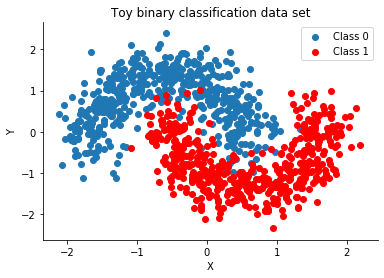

In [2]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.90)

fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

# Create the grid for classification

In [3]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).transpose()

# Data With Algorithms Uncertainty Bounds

In [4]:
def plot_uncertainty_gird(prediction, new_indices = None):
    cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
    fig, ax = plt.subplots(figsize=(16, 9))
    contour = ax.contourf(grid[1], grid[0], prediction.reshape(100, 100).transpose(), cmap=cmap)
    ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1])
    ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
    if new_indices is not None:
        ax.scatter(X_test[new_indices,0],X_test[new_indices,1], color='k')
    cbar = plt.colorbar(contour, ax=ax)
    _ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
    cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

# Train a Model and Get Predictions on a Grid

In [5]:
peony_model = PeonyBoxModel(None, active_learning_step=10, acquisition_function=entropy_sampling)
peony_model.bayesian_denfi_nn.fit(X_train, Y_train, False)
peony_model.bayesian_denfi_nn.epsilon_greedy_coef = 1
peony_model.bayesian_denfi_nn.active_learning_iteration = 100
first_iter = peony_model.bayesian_denfi_nn.predict(grid_2d, False)

# Visualize Last 100 Loss Values With Respect To Ensembles

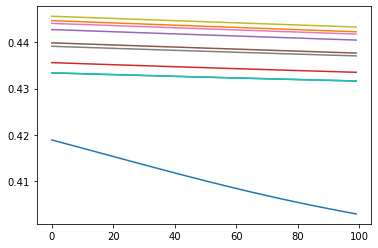

In [6]:
for curve in peony_model.bayesian_denfi_nn.model.loss_sequence:
    plt.plot(curve[1900:2000]) 

# Get Maximal Entropy Labels, Retrain and Get Predictions on a Grid

In [7]:
indices  = peony_model.bayesian_denfi_nn.get_learning_samples(X_test, False)
peony_model.bayesian_denfi_nn.add_new_learning_samples(X_test[indices[0]].reshape(1,2), Y_test[indices[0]].reshape(1), False)
second_iter = peony_model.bayesian_denfi_nn.predict(grid_2d, False)

# Visualize Last 100 Loss Values With Respect To Ensembles

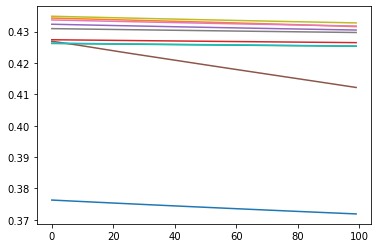

In [8]:
for curve in peony_model.bayesian_denfi_nn.model.loss_sequence:
    plt.plot(curve[-100:]) 

# Plots on The Grid With Respect to 1 Active Learning Iteration

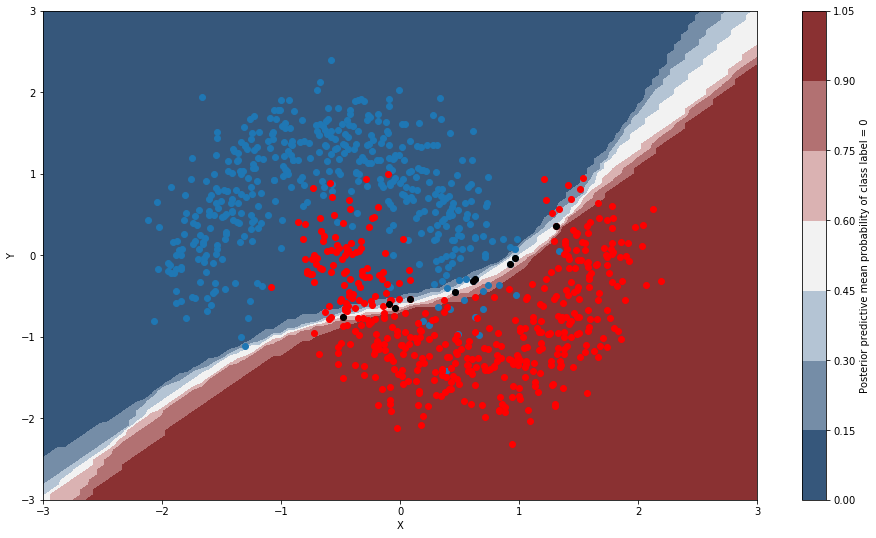

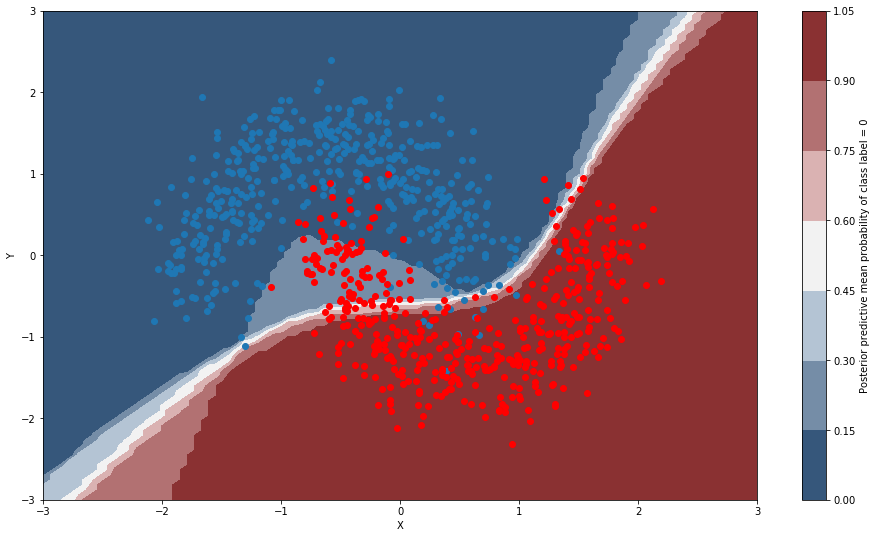

In [9]:
plot_uncertainty_gird(first_iter,indices)
plot_uncertainty_gird(second_iter)